# Visualise the network of Australian people identifiers

Wikidata uses a wide range of external identifiers to help describe and identify people. This notebook explores the range of identifiers applied to Australian people in Wikidata and attempts to visualise their use and connections.

In [18]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import time
from urllib.error import HTTPError

import altair as alt
import pandas as pd
from pyvis.network import Network
from SPARQLWrapper.sparql_dataframe import get_sparql_dataframe
from tqdm.auto import tqdm
from upsetplot import UpSet, from_memberships

As a first step we'll find the range of identifiers applied to Australian people in Wikidata. We'll limit this to identifiers from Australian sources, such as Trove, or the Australian Dictionary of Biography. You can view [the results of this query](https://w.wiki/F4kL) using the Wikidata Query Service.

In [9]:
# This query gets all Australian identifiers applied to people.
query = """
SELECT DISTINCT ?property ?propertyLabel WHERE {
    ?item wdt:P31 wd:Q5.
    ?item ?propertyclaim [].
    ?property wikibase:propertyType wikibase:ExternalId;
        wdt:P17 wd:Q408;
        wikibase:directClaim ?propertyclaim.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO LANGUAGE],en". }
}
"""

df_ids = get_sparql_dataframe("https://query.wikidata.org/sparql", query)

In [10]:
df_ids

,property,propertyLabel
0,http://www.wikidata.org/entity/P409,Libraries Australia ID
1,http://www.wikidata.org/entity/P8633,OLD Re-Member ID
2,http://www.wikidata.org/entity/P9244,Women Australia ID
3,http://www.wikidata.org/entity/P9245,Labour Australia ID
4,http://www.wikidata.org/entity/P9246,Indigenous Australia ID
...,...,...
73,http://www.wikidata.org/entity/P11758,WPGA Tour Australasia player ID
74,http://www.wikidata.org/entity/P10249,Triple J Unearthed artist ID
75,http://www.wikidata.org/entity/P11281,Biographical Dictionary of the Australian Sena...
76,http://www.wikidata.org/entity/P10215,Casefile ID


In [4]:
df_ids.to_csv("australian-identifiers.csv", index=False)

Now we want to explore how these different identifiers are connected. For each identifier, we run a query to find all the records of Australian people that use the identifier, then we get details of all the other identifiers used in these records, and count the number of times each pair of identifiers occurs.

In [ ]:
# This query finds all the people who have a specific identifier.
# It then gets a count of any other Australian identifiers attached to these records.
query_template = """
SELECT DISTINCT ?target_prop ?count WHERE {{
  {{
    SELECT ?propertyclaim (COUNT(*) AS ?count) where {{
      ?item wdt:P31 wd:Q5;
          wdt:{} ?aus_id.
      ?item ?propertyclaim [].
    }} GROUP BY ?propertyclaim
  }}
  ?target_prop wikibase:propertyType wikibase:ExternalId;
      wdt:P17 wd:Q408;
      wikibase:directClaim ?propertyclaim.
}} ORDER BY DESC (?count)
"""

dfs = []

for prop in tqdm(df_ids.to_dict(orient="records")):
    prop_id = prop["property"].split("/")[-1]
    query = query_template.format(prop_id)
    try:
        df = get_sparql_dataframe("https://query.wikidata.org/sparql", query)
    except HTTPError as e:
        print(e.hdrs)
        raise
    df["source"] = prop["propertyLabel"]
    df["source_prop"] = prop["property"]
    dfs.append(df)
    time.sleep(5)

In [22]:
df_all = pd.concat(dfs)

Using the CSV created above, I categorised the identifiers as one of "arts", "politics", "sport", or "other" and saved the results to a different CSV file. We can use these groupings to colour the nodes.

In [23]:
# Import the CSV file with categories
df_topics = pd.read_csv("australian-identifiers-topics.csv")
# Create a df with just the source info for easy merging
sources = df_all[["source_prop", "source"]].drop_duplicates()

In [24]:
# Add the topic for source nodes
df_all = pd.merge(
    df_all, df_topics, how="left", left_on="source_prop", right_on="property"
)
# Add the topic for target nodes
df_all = pd.merge(
    df_all,
    df_topics,
    how="left",
    left_on="target_prop",
    right_on="property",
    suffixes=["_source", "_target"],
)
# Add the name of target nodes
df_all = pd.merge(
    df_all,
    sources,
    how="left",
    left_on="target_prop",
    right_on="source_prop",
    suffixes=[None, "_target"],
)
# Clean up
df_all = df_all[
    [
        "source_prop",
        "source",
        "topic_source",
        "target_prop",
        "source_target",
        "topic_target",
        "count",
    ]
]
df_all

,source_prop,source,topic_source,target_prop,source_target,topic_target,count
0,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,98542
1,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P1315,NLA Trove people ID,other,72907
2,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P9159,People Australia ID,other,2493
3,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P1907,Australian Dictionary of Biography ID,other,2385
4,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P4228,Encyclopedia of Australian Science ID,other,1253
...,...,...,...,...,...,...,...
1635,http://www.wikidata.org/entity/P10215,Casefile ID,other,http://www.wikidata.org/entity/P9245,Labour Australia ID,other,1
1636,http://www.wikidata.org/entity/P10233,NER portfolio ID,other,http://www.wikidata.org/entity/P10233,NER portfolio ID,other,4
1637,http://www.wikidata.org/entity/P10233,NER portfolio ID,other,http://www.wikidata.org/entity/P1315,NLA Trove people ID,other,1
1638,http://www.wikidata.org/entity/P10233,NER portfolio ID,other,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,1


In [25]:
df_all.to_csv("australian-identifiers-links.csv", index=False)

Results where the source and target properties are the same tell us the number of times each identifier is used. Here we separate out these results and merge them with the topic data, so we have a row for each identifier that tells us the number of time it is used, and the group it belongs to. We'll use this data to create a list of nodes.

In [ ]:
# Uncomment for testing or to reuse pre-harvested data
# df_all = pd.read_csv("australian-identifiers-links.csv")

In [26]:
nodes = df_all.loc[df_all["source_prop"] == df_all["target_prop"]]
nodes

,source_prop,source,topic_source,target_prop,source_target,topic_target,count
0,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,98542
55,http://www.wikidata.org/entity/P8633,OLD Re-Member ID,politics,http://www.wikidata.org/entity/P8633,OLD Re-Member ID,politics,1266
85,http://www.wikidata.org/entity/P9244,Women Australia ID,other,http://www.wikidata.org/entity/P9244,Women Australia ID,other,3479
125,http://www.wikidata.org/entity/P9245,Labour Australia ID,other,http://www.wikidata.org/entity/P9245,Labour Australia ID,other,918
164,http://www.wikidata.org/entity/P9246,Indigenous Australia ID,other,http://www.wikidata.org/entity/P9246,Indigenous Australia ID,other,318
...,...,...,...,...,...,...,...
1597,http://www.wikidata.org/entity/P11758,WPGA Tour Australasia player ID,sport,http://www.wikidata.org/entity/P11758,WPGA Tour Australasia player ID,sport,45
1601,http://www.wikidata.org/entity/P10249,Triple J Unearthed artist ID,arts,http://www.wikidata.org/entity/P10249,Triple J Unearthed artist ID,arts,30
1604,http://www.wikidata.org/entity/P11281,Biographical Dictionary of the Australian Sena...,politics,http://www.wikidata.org/entity/P11281,Biographical Dictionary of the Australian Sena...,politics,426
1628,http://www.wikidata.org/entity/P10215,Casefile ID,other,http://www.wikidata.org/entity/P10215,Casefile ID,other,35


In [27]:
alt.Chart(nodes).mark_bar().encode(
    x=alt.X("source:N").sort("-y"), y="count:Q", color="topic_source:N"
)

alt.Chart(...)

In [28]:
alt.Chart(
    nodes.loc[nodes["topic_source"].isin(["arts", "politics", "sport"])]
).mark_bar().encode(x=alt.X("source:N").sort("-y"), y="count:Q", color="topic_source:N")

alt.Chart(...)

Results where the source and target properties are different tell us the number of times different combinations of identifiers are linked. We'll separate out this data to provide a list of "edges" between nodes.

In [29]:
edges = df_all.loc[df_all["source_prop"] != df_all["target_prop"]]

In [30]:
edges

,source_prop,source,topic_source,target_prop,source_target,topic_target,count
1,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P1315,NLA Trove people ID,other,72907
2,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P9159,People Australia ID,other,2493
3,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P1907,Australian Dictionary of Biography ID,other,2385
4,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P4228,Encyclopedia of Australian Science ID,other,1253
5,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,http://www.wikidata.org/entity/P2041,National Gallery of Victoria artist ID,arts,1249
...,...,...,...,...,...,...,...
1634,http://www.wikidata.org/entity/P10215,Casefile ID,other,http://www.wikidata.org/entity/P10012,NSW Parliament member ID,politics,1
1635,http://www.wikidata.org/entity/P10215,Casefile ID,other,http://www.wikidata.org/entity/P9245,Labour Australia ID,other,1
1637,http://www.wikidata.org/entity/P10233,NER portfolio ID,other,http://www.wikidata.org/entity/P1315,NLA Trove people ID,other,1
1638,http://www.wikidata.org/entity/P10233,NER portfolio ID,other,http://www.wikidata.org/entity/P409,Libraries Australia ID,other,1


In [63]:
def create_graph(nodes, edges, new_range=None, colours=None):
    net = Network(
        notebook=True, width=800, height=600, directed=True, cdn_resources="in_line"
    )

    # Do some normalisation of sizes.
    old_max = nodes["count"].max()
    old_min = nodes["count"].min()
    old_range = old_max - old_min
    if not new_range:
        new_range = old_range

    # Create nodes, assigning the count to the size property, and using the topic to set a colour
    for node in nodes.itertuples():
        node_id = node.source_prop.split("/")[-1]
        net.add_node(
            node_id,
            label=node_id,
            title=f"{node.source} ({node.count:,})",
            size=((node.count * new_range) / old_range) + 20,
            color=colours[node.topic_source] if colours else None,
        )

    # Create edges
    for edge in edges.itertuples():
        source_id = edge.source_prop.split("/")[-1]
        target_id = edge.target_prop.split("/")[-1]
        net.add_edge(source_id, target_id, value=int(edge.count))

    graph_config = """
    var options = {
        "configure": {
                "enabled": false
        },
        "nodes": {
            "color": {
                "background": "#7986cb",
                "border": "#49599a",
                "highlight": {
                    "background": "#aab6fe",
                    "border": "#7986cb"
                }
            },
            "font": {
                "size": 20
            }
        },
        "edges": {
            "color": {
                "color": "#b0bec5",
                "highlight": "#808e95",
                "inherit": false
            }
        },
        "physics": {
            "barnesHut": {
                "gravitationalConstant": -30000,
                  "centralGravity": 0,
                  "springLength": 500,
                  "springConstant": 0.01
                },
            "minVelocity": 0.75
        }
    }
    """

    net.set_options(graph_config)
    return net


def filter_nodes(nodes, edges, topics, new_range=None, colours=None):
    select_nodes = nodes.loc[nodes["topic_source"].isin(topics)]
    select_nodes_ids = select_nodes["source_prop"].to_list()
    select_edges = edges.loc[
        (edges["source_prop"].isin(select_nodes_ids))
        & (edges["target_prop"].isin(select_nodes_ids))
    ]
    return create_graph(
        select_nodes, select_edges, new_range=new_range, colours=colours
    )

Now we create a network graph using Pyvis, feeding in the node and edges data we've assembled.

In [64]:
# Assign each topic group a colour
colours = {
    "sport": "#1f77b4",
    "politics": "#ff7f0e",
    "arts": "#2ca02c",
    "other": "#d62728",
}

net = create_graph(nodes=nodes, edges=edges, new_range=500, colours=colours)
net.show("aus_ids.html")

aus_ids.html


In [65]:
net = filter_nodes(
    nodes, edges, ["arts", "politics", "sport"], new_range=200, colours=colours
)
net.show("arts_politics_sport_ids.html")

arts_politics_sport_ids.html


In [66]:
net = filter_nodes(nodes, edges, ["arts"], new_range=200, colours=colours)
net.show("arts_ids.html")

arts_ids.html


## Exploring intersections

The network graphs show how groups of identifiers are connected. We can look more closely at their intersections using an upset chart. 

In [87]:
top_pairs = df_all.copy().loc[
    (df_all["source"] != df_all["source_target"])
    & (df_all["count"] > 20)
    & (df_all["topic_source"].isin(["arts"]))
    & (df_all["topic_target"].isin(["arts"]))
]
top_pairs["pair"] = top_pairs.apply(
    lambda x: "|".join(sorted([x["source"], x["source_target"]])), axis=1
)
top_pairs.drop_duplicates(subset=["pair"], inplace=True)

In [88]:
def make_upset(pairs, size=40):
    intersections = from_memberships(
        pairs[["source", "source_target"]].values.tolist(), pairs
    )
    chart = UpSet(
        intersections,
        sum_over="count",
        min_degree=2,
        show_counts=True,
        sort_by="cardinality",
        intersection_plot_elements=8,
        totals_plot_elements=4,
        facecolor="#002984",
        element_size=size,
    )
    return chart

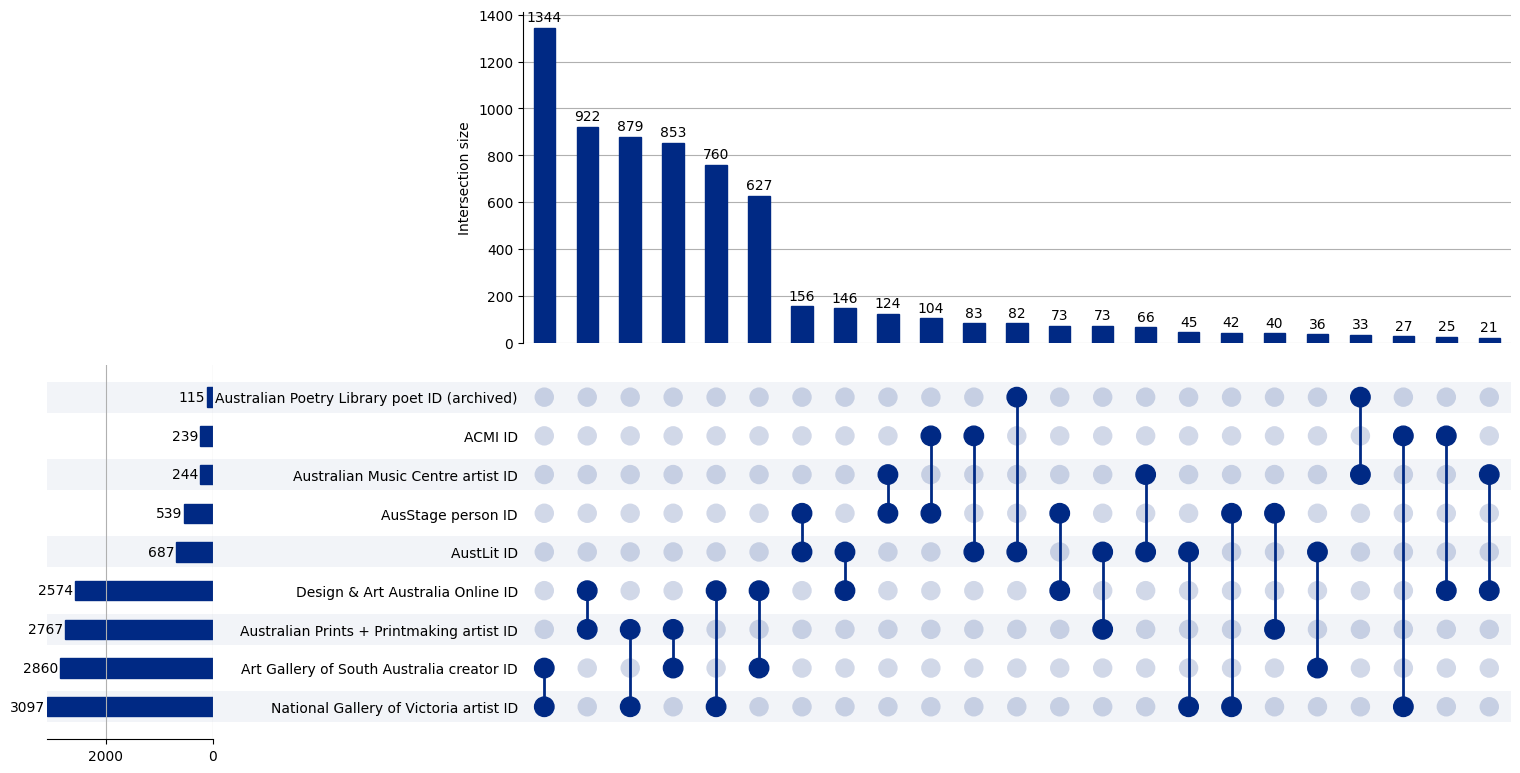

In [90]:
upset_chart = make_upset(top_pairs)
upset_chart

In [113]:
adb_pairs = df_all.copy().loc[
    (df_all["source"] != df_all["source_target"])
    & (df_all["source"] == "Australian Dictionary of Biography ID")
    & (df_all["topic_target"].isin(["arts"]))
]

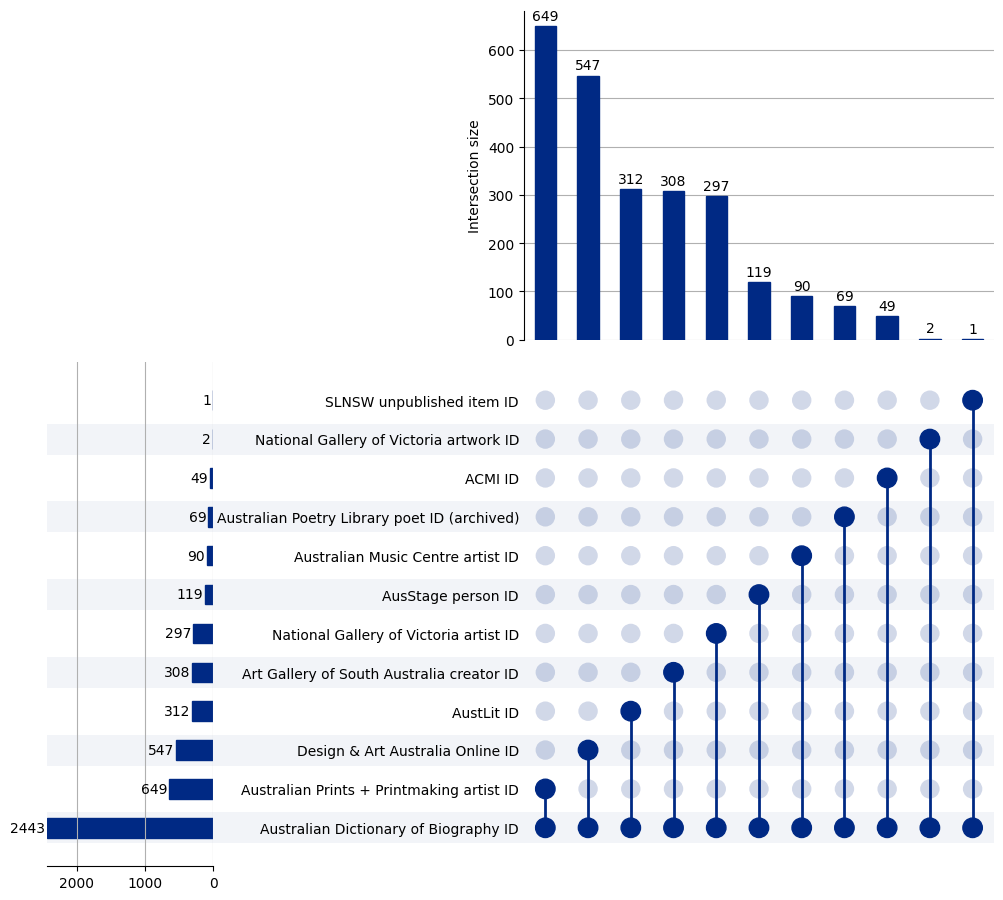

In [114]:
upset_chart = make_upset(adb_pairs)
upset_chart